<a href="https://colab.research.google.com/github/GURRALASAIHANEESH/Fashion_Visual_Search/blob/main/Fashion_Visual_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Install a specific stable version
!pip install aioredis==1.3.1

In [ ]:
!pip install aioredis==2.0.1

  Using cached aioredis-2.0.1-py3-none-any.whl.metadata (15 kB)
Using cached aioredis-2.0.1-py3-none-any.whl (71 kB)
  Attempting uninstall: aioredis
    Found existing installation: aioredis 1.3.1
    Uninstalling aioredis-1.3.1:
      Successfully uninstalled aioredis-1.3.1


In [ ]:
!find /content -name "jeans_bd_processed_data.csv"
!find /content -name "dresses_bd_processed_data.csv"

In [ ]:

!mkdir -p /content/fashion-project  # Create directory

In [ ]:
import os
os.chdir('/content/fashion-project')  # Go to your working directory
print("Current directory:", os.getcwd())
print("Files present:", os.listdir())  # This should show your CSV files if they exist

Current directory: /content/fashion-project
Files present: ['fashion-project']


In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/jeans_bd_processed_data.csv /content/fashion-project/
!cp /content/drive/MyDrive/Colab\ Notebooks/dresses_bd_processed_data.csv /content/fashion-project/

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Create backup directory in Drive
!mkdir -p '/content/drive/MyDrive/Fashion-Data-Backup'

# Copy current files to Drive
!cp '/content/fashion-project/jeans_bd_processed_data.csv' '/content/drive/MyDrive/Fashion-Data-Backup/'
!cp '/content/fashion-project/dresses_bd_processed_data.csv' '/content/drive/MyDrive/Fashion-Data-Backup/'

print("CSV files successfully backed up to Google Drive!")

Mounted at /content/drive
CSV files successfully backed up to Google Drive!


In [ ]:
!pip install -q pandas numpy requests pillow tensorflow faiss-cpu scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 61.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import json
import os

# Load your datasets
dresses = pd.read_csv('dresses_bd_processed_data.csv')
jeans = pd.read_csv('jeans_bd_processed_data.csv')

# Combine datasets
combined = pd.concat([dresses, jeans], ignore_index=True)
print(f"Total products: {len(combined)}")

# Create folder for images
os.makedirs('images', exist_ok=True)

# Save processed data
combined.to_parquet('fashion_catalog.parquet', index=False)
print("Data preparation complete!")

Total products: 17483
Data preparation complete!


In [ ]:
import aiohttp
import asyncio
from PIL import Image
from io import BytesIO
import pandas as pd
from tqdm.asyncio import tqdm
import os

# Load catalog
df = pd.read_parquet('/content/fashion-project/fashion_catalog.parquet')

# Ensure images directory exists
os.makedirs('/content/fashion-project/images', exist_ok=True)

async def download_image(session, url, product_id):
    try:
        async with session.get(url, timeout=10) as response:
            if response.status == 200:
                img_data = await response.read()
                img = Image.open(BytesIO(img_data))
                img = img.resize((224, 224)).convert('RGB')
                img.save(f'/content/fashion-project/images/{product_id}.jpg')
                return True
    except Exception:
        return False
    return False

async def download_images_batch(tasks):
    async with aiohttp.ClientSession() as session:
        results = await asyncio.gather(*[download_image(session, url, pid) for url, pid in tasks], return_exceptions=True)
        return sum(1 for r in results if r is True)

async def main():
    tasks = [(row['feature_image_s3'], row['product_id']) for _, row in df.iterrows()]
    success_count = 0
    batch_size = 20  # Adjust based on server limits
    for i in tqdm(range(0, len(tasks), batch_size), desc="Downloading images"):
        batch = tasks[i:i+batch_size]
        success_count += await download_images_batch(batch)
        await asyncio.sleep(0.05)  # Small delay to avoid overwhelming servers
    print(f"\nSuccessfully downloaded {success_count}/{len(df)} images")

# Run the async function
await main()


Successfully downloaded 17483/17483 images


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import os
import pandas as pd

# Initialize model
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Batch processing function
def extract_features_batch(img_paths):
    batch = np.array([image.img_to_array(image.load_img(img, target_size=(224, 224))) for img in img_paths])
    batch = tf.keras.applications.efficientnet.preprocess_input(batch)
    return model.predict(batch, batch_size=32)

# Single image processing function
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

# Get all image paths
img_dir = '/content/fashion-project/images'
if not os.path.exists(img_dir):
    print(f"Error: Directory {img_dir} does not exist. Please create it and add .jpg files.")
else:
    all_images = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]
    if not all_images:
        print(f"Error: No .jpg files found in {img_dir}.")
    else:
        # Process in batches and track valid IDs
        features = []
        valid_ids = []
        for i in tqdm(range(0, len(all_images), 32), desc="Extracting features"):
            batch_paths = all_images[i:i+32]
            try:
                batch_features = extract_features_batch(batch_paths)
                features.extend(batch_features)
                valid_ids.extend([os.path.splitext(os.path.basename(path))[0] for path in batch_paths])
            except Exception as e:
                print(f"Error processing batch {batch_paths}: {e}")

        # Save results
        if features and valid_ids:
            np.save('/content/fashion-project/image_features.npy', np.array(features))
            pd.DataFrame(valid_ids, columns=['id']).to_csv('/content/fashion-project/valid_ids.csv', index=False)
            print("Saved image_features.npy and valid_ids.csv successfully!")
        else:
            print("No features or IDs extracted. Check image files.")

# Test a single image (replace 'test_image.jpg' with an actual image name from images/)
test_img_name = '/content/fashion-project/images/test_image.jpg'  # Update with a valid image path
if os.path.exists(test_img_name):
    test_features = extract_features(test_img_name)
    test_features = test_features.astype('float32')
    faiss.normalize_L2(test_features.reshape(1, -1))
    print("Test image features extracted successfully!")
else:
    print(f"Test image {test_img_name} not found.")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting features:   0%|          | 0/547 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Extracting features:   0%|          | 1/547 [00:06<59:43,  6.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   0%|          | 2/547 [00:08<35:55,  3.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   1%|          | 3/547 [00:11<30:28,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   1%|          | 4/547 [00:13<25:39,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   1%|          | 5/547 [00:15<22:54,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   1%|          | 6/547 [00:20<31:03,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   1%|▏         | 7/547 [00:23<28:39,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   1%|▏         | 8/547 [00:25<27:03,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   2%|▏         | 9/547 [00:27<24:18,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   2%|▏         | 10/547 [00:30<23:19,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   2%|▏         | 11/547 [00:33<24:34,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   2%|▏         | 12/547 [00:35<22:19,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   2%|▏         | 13/547 [00:37<22:39,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   3%|▎         | 14/547 [00:40<22:52,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   3%|▎         | 15/547 [00:43<23:00,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   3%|▎         | 16/547 [00:46<24:45,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   3%|▎         | 17/547 [00:48<22:55,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   3%|▎         | 18/547 [00:51<23:00,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   3%|▎         | 19/547 [00:53<23:01,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   4%|▎         | 20/547 [00:56<22:59,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   4%|▍         | 21/547 [01:01<29:41,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   4%|▍         | 22/547 [01:03<25:48,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   4%|▍         | 23/547 [01:06<24:53,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   4%|▍         | 24/547 [01:08<24:15,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   5%|▍         | 25/547 [01:11<23:49,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   5%|▍         | 26/547 [01:16<30:18,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   5%|▍         | 27/547 [01:19<28:02,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   5%|▌         | 28/547 [01:22<26:26,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   5%|▌         | 29/547 [01:23<23:25,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   5%|▌         | 30/547 [01:29<29:45,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   6%|▌         | 31/547 [01:31<25:44,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   6%|▌         | 32/547 [01:33<24:43,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   6%|▌         | 33/547 [01:36<24:01,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   6%|▌         | 34/547 [01:38<22:33,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   6%|▋         | 35/547 [01:41<23:45,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   7%|▋         | 36/547 [01:43<21:32,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   7%|▋         | 37/547 [01:46<21:46,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   7%|▋         | 38/547 [01:48<20:05,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   7%|▋         | 39/547 [01:50<18:55,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   7%|▋         | 40/547 [01:52<18:52,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   7%|▋         | 41/547 [01:57<26:24,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   8%|▊         | 42/547 [01:59<23:21,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   8%|▊         | 43/547 [02:02<22:58,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   8%|▊         | 44/547 [02:04<22:42,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   8%|▊         | 45/547 [02:07<22:37,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   8%|▊         | 46/547 [02:10<22:44,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   9%|▊         | 47/547 [02:12<22:30,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   9%|▉         | 48/547 [02:14<20:29,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   9%|▉         | 49/547 [02:17<20:53,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:   9%|▉         | 50/547 [02:20<21:08,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:   9%|▉         | 51/547 [02:23<22:34,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  10%|▉         | 52/547 [02:25<22:17,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  10%|▉         | 53/547 [02:27<20:18,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  10%|▉         | 54/547 [02:30<20:38,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  10%|█         | 55/547 [02:33<20:51,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  10%|█         | 56/547 [02:38<27:17,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  10%|█         | 57/547 [02:40<23:48,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  11%|█         | 58/547 [02:42<21:15,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  11%|█         | 59/547 [02:43<19:35,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  11%|█         | 60/547 [02:46<20:05,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  11%|█         | 61/547 [02:51<26:42,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  11%|█▏        | 62/547 [02:54<25:04,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  12%|█▏        | 63/547 [02:57<23:55,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  12%|█▏        | 64/547 [02:59<21:24,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  12%|█▏        | 65/547 [03:01<21:17,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  12%|█▏        | 66/547 [03:04<21:43,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  12%|█▏        | 67/547 [03:06<19:45,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  12%|█▏        | 68/547 [03:08<18:19,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  13%|█▎        | 69/547 [03:10<19:04,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  13%|█▎        | 70/547 [03:12<18:06,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  13%|█▎        | 71/547 [03:15<18:23,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  13%|█▎        | 72/547 [03:20<25:15,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  13%|█▎        | 73/547 [03:23<23:51,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  14%|█▎        | 74/547 [03:25<22:53,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  14%|█▎        | 75/547 [03:27<20:33,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  14%|█▍        | 76/547 [03:30<21:13,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  14%|█▍        | 77/547 [03:33<20:42,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  14%|█▍        | 78/547 [03:35<20:39,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  14%|█▍        | 79/547 [03:38<20:33,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  15%|█▍        | 80/547 [03:41<20:28,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  15%|█▍        | 81/547 [03:43<20:24,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  15%|█▍        | 82/547 [03:46<20:59,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  15%|█▌        | 83/547 [03:49<20:44,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  15%|█▌        | 84/547 [03:51<18:55,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  16%|█▌        | 85/547 [03:53<17:40,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  16%|█▌        | 86/547 [03:55<18:23,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  16%|█▌        | 87/547 [04:00<24:45,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  16%|█▌        | 88/547 [04:03<23:18,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  16%|█▋        | 89/547 [04:06<22:16,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  16%|█▋        | 90/547 [04:08<21:32,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  17%|█▋        | 91/547 [04:11<21:09,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  17%|█▋        | 92/547 [04:14<21:04,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  17%|█▋        | 93/547 [04:16<20:42,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  17%|█▋        | 94/547 [04:19<20:24,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  17%|█▋        | 95/547 [04:21<18:38,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  18%|█▊        | 96/547 [04:23<17:20,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  18%|█▊        | 97/547 [04:28<23:46,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  18%|█▊        | 98/547 [04:31<22:29,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  18%|█▊        | 99/547 [04:33<21:35,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  18%|█▊        | 100/547 [04:36<20:55,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  18%|█▊        | 101/547 [04:41<26:10,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  19%|█▊        | 102/547 [04:43<22:36,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  19%|█▉        | 103/547 [04:46<21:35,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  19%|█▉        | 104/547 [04:48<20:53,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  19%|█▉        | 105/547 [04:51<20:23,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  19%|█▉        | 106/547 [04:54<20:39,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  20%|█▉        | 107/547 [04:56<20:11,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  20%|█▉        | 108/547 [04:59<19:52,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  20%|█▉        | 109/547 [05:01<18:05,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  20%|██        | 110/547 [05:03<16:50,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  20%|██        | 111/547 [05:06<17:51,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  20%|██        | 112/547 [05:08<18:15,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  21%|██        | 113/547 [05:11<18:26,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  21%|██        | 114/547 [05:13<17:07,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  21%|██        | 115/547 [05:16<17:39,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  21%|██        | 116/547 [05:18<18:01,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  21%|██▏       | 117/547 [05:23<23:48,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  22%|██▏       | 118/547 [05:26<22:14,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  22%|██▏       | 119/547 [05:29<21:10,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  22%|██▏       | 120/547 [05:31<18:56,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  22%|██▏       | 121/547 [05:36<24:15,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  22%|██▏       | 122/547 [05:38<21:01,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  22%|██▏       | 123/547 [05:40<20:13,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  23%|██▎       | 124/547 [05:42<18:09,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  23%|██▎       | 125/547 [05:44<16:51,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  23%|██▎       | 126/547 [05:49<22:40,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  23%|██▎       | 127/547 [05:52<21:20,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  23%|██▎       | 128/547 [05:54<18:54,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  24%|██▎       | 129/547 [05:56<17:13,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  24%|██▍       | 130/547 [05:58<16:00,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  24%|██▍       | 131/547 [06:01<17:39,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  24%|██▍       | 132/547 [06:03<17:09,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  24%|██▍       | 133/547 [06:06<17:24,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  24%|██▍       | 134/547 [06:08<16:07,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  25%|██▍       | 135/547 [06:10<16:39,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  25%|██▍       | 136/547 [06:13<17:01,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  25%|██▌       | 137/547 [06:16<17:56,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  25%|██▌       | 138/547 [06:19<17:52,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  25%|██▌       | 139/547 [06:21<17:51,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  26%|██▌       | 140/547 [06:24<17:48,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  26%|██▌       | 141/547 [06:26<17:45,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  26%|██▌       | 142/547 [06:29<18:25,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  26%|██▌       | 143/547 [06:31<16:44,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  26%|██▋       | 144/547 [06:34<16:58,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  27%|██▋       | 145/547 [06:37<17:07,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  27%|██▋       | 146/547 [06:39<17:12,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  27%|██▋       | 147/547 [06:42<18:13,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  27%|██▋       | 148/547 [06:45<18:02,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  27%|██▋       | 149/547 [06:48<17:49,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  27%|██▋       | 150/547 [06:50<17:38,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  28%|██▊       | 151/547 [06:53<17:29,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  28%|██▊       | 152/547 [06:56<17:51,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  28%|██▊       | 153/547 [06:58<17:43,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  28%|██▊       | 154/547 [07:01<17:33,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  28%|██▊       | 155/547 [07:03<15:59,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  29%|██▊       | 156/547 [07:05<16:18,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  29%|██▊       | 157/547 [07:08<16:30,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  29%|██▉       | 158/547 [07:11<17:17,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  29%|██▉       | 159/547 [07:14<17:09,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  29%|██▉       | 160/547 [07:16<17:03,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  29%|██▉       | 161/547 [07:19<16:58,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  30%|██▉       | 162/547 [07:22<16:54,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  30%|██▉       | 163/547 [07:25<17:30,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  30%|██▉       | 164/547 [07:26<15:54,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  30%|███       | 165/547 [07:29<16:09,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  30%|███       | 166/547 [07:31<14:56,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  31%|███       | 167/547 [07:34<15:25,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  31%|███       | 168/547 [07:37<16:08,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  31%|███       | 169/547 [07:39<16:17,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  31%|███       | 170/547 [07:42<16:20,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  31%|███▏      | 171/547 [07:44<16:19,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  31%|███▏      | 172/547 [07:46<14:59,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  32%|███▏      | 173/547 [07:48<14:05,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  32%|███▏      | 174/547 [07:53<19:30,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  32%|███▏      | 175/547 [07:56<18:29,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  32%|███▏      | 176/547 [07:59<17:46,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  32%|███▏      | 177/547 [08:01<17:15,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  33%|███▎      | 178/547 [08:04<17:06,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  33%|███▎      | 179/547 [08:09<21:33,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  33%|███▎      | 180/547 [08:12<19:51,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  33%|███▎      | 181/547 [08:15<18:39,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  33%|███▎      | 182/547 [08:17<17:49,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  33%|███▎      | 183/547 [08:22<21:57,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  34%|███▎      | 184/547 [08:24<18:50,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  34%|███▍      | 185/547 [08:27<17:53,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  34%|███▍      | 186/547 [08:29<15:57,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  34%|███▍      | 187/547 [08:31<15:50,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  34%|███▍      | 188/547 [08:37<20:25,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  35%|███▍      | 189/547 [08:39<18:59,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  35%|███▍      | 190/547 [08:42<17:57,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  35%|███▍      | 191/547 [08:45<17:12,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  35%|███▌      | 192/547 [08:50<21:15,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  35%|███▌      | 193/547 [08:52<19:29,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  35%|███▌      | 194/547 [08:55<18:13,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  36%|███▌      | 195/547 [08:57<16:06,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  36%|███▌      | 196/547 [09:02<20:20,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  36%|███▌      | 197/547 [09:04<17:31,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  36%|███▌      | 198/547 [09:06<15:36,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  36%|███▋      | 199/547 [09:09<15:27,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  37%|███▋      | 200/547 [09:11<15:20,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  37%|███▋      | 201/547 [09:14<16:10,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  37%|███▋      | 202/547 [09:16<14:37,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  37%|███▋      | 203/547 [09:19<14:43,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  37%|███▋      | 204/547 [09:22<14:46,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  37%|███▋      | 205/547 [09:24<13:36,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  38%|███▊      | 206/547 [09:26<13:58,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  38%|███▊      | 207/547 [09:31<18:37,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  38%|███▊      | 208/547 [09:34<17:26,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  38%|███▊      | 209/547 [09:37<16:35,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  38%|███▊      | 210/547 [09:39<15:59,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  39%|███▊      | 211/547 [09:44<19:56,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  39%|███▉      | 212/547 [09:47<18:19,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  39%|███▉      | 213/547 [09:49<16:00,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  39%|███▉      | 214/547 [09:52<15:32,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  39%|███▉      | 215/547 [09:55<15:48,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  39%|███▉      | 216/547 [09:57<15:25,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  40%|███▉      | 217/547 [10:00<15:06,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  40%|███▉      | 218/547 [10:02<13:41,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  40%|████      | 219/547 [10:04<13:51,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  40%|████      | 220/547 [10:07<13:57,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  40%|████      | 221/547 [10:12<18:14,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  41%|████      | 222/547 [10:14<15:53,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  41%|████      | 223/547 [10:17<15:19,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  41%|████      | 224/547 [10:19<13:47,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  41%|████      | 225/547 [10:21<13:51,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  41%|████▏     | 226/547 [10:27<18:02,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  41%|████▏     | 227/547 [10:29<16:48,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  42%|████▏     | 228/547 [10:32<15:55,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  42%|████▏     | 229/547 [10:34<15:16,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  42%|████▏     | 230/547 [10:40<18:55,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  42%|████▏     | 231/547 [10:42<17:21,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  42%|████▏     | 232/547 [10:44<15:10,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  43%|████▎     | 233/547 [10:47<14:41,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  43%|████▎     | 234/547 [10:52<18:22,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  43%|████▎     | 235/547 [10:55<16:54,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  43%|████▎     | 236/547 [10:57<15:53,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  43%|████▎     | 237/547 [11:00<15:09,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  44%|████▎     | 238/547 [11:05<18:35,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  44%|████▎     | 239/547 [11:07<15:55,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  44%|████▍     | 240/547 [11:10<15:08,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  44%|████▍     | 241/547 [11:12<14:34,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  44%|████▍     | 242/547 [11:14<13:30,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  44%|████▍     | 243/547 [11:18<14:25,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  45%|████▍     | 244/547 [11:20<14:03,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  45%|████▍     | 245/547 [11:22<12:43,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  45%|████▍     | 246/547 [11:25<12:49,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  45%|████▌     | 247/547 [11:28<12:52,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  45%|████▌     | 248/547 [11:31<13:38,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  46%|████▌     | 249/547 [11:33<12:57,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  46%|████▌     | 250/547 [11:36<12:55,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  46%|████▌     | 251/547 [11:38<11:51,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  46%|████▌     | 252/547 [11:39<11:07,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  46%|████▋     | 253/547 [11:42<11:37,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  46%|████▋     | 254/547 [11:47<15:44,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  47%|████▋     | 255/547 [11:49<13:45,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  47%|████▋     | 256/547 [11:51<12:25,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  47%|████▋     | 257/547 [11:54<12:28,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  47%|████▋     | 258/547 [11:56<12:29,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  47%|████▋     | 259/547 [11:59<12:56,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  48%|████▊     | 260/547 [12:01<11:46,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  48%|████▊     | 261/547 [12:03<10:58,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  48%|████▊     | 262/547 [12:06<11:23,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  48%|████▊     | 263/547 [12:08<10:43,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  48%|████▊     | 264/547 [12:10<11:12,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  48%|████▊     | 265/547 [12:13<11:57,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  49%|████▊     | 266/547 [12:15<11:05,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  49%|████▉     | 267/547 [12:18<11:24,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  49%|████▉     | 268/547 [12:21<11:36,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  49%|████▉     | 269/547 [12:23<11:44,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  49%|████▉     | 270/547 [12:26<12:39,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  50%|████▉     | 271/547 [12:28<11:39,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  50%|████▉     | 272/547 [12:30<10:47,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  50%|████▉     | 273/547 [12:32<10:08,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  50%|█████     | 274/547 [12:35<10:39,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  50%|█████     | 275/547 [12:37<10:06,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  50%|█████     | 276/547 [12:42<14:07,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  51%|█████     | 277/547 [12:44<12:26,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  51%|█████     | 278/547 [12:47<12:12,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  51%|█████     | 279/547 [12:49<12:02,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  51%|█████     | 280/547 [12:52<11:54,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  51%|█████▏    | 281/547 [12:55<12:04,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  52%|█████▏    | 282/547 [12:57<11:54,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  52%|█████▏    | 283/547 [13:00<11:45,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  52%|█████▏    | 284/547 [13:02<10:43,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  52%|█████▏    | 285/547 [13:04<09:56,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  52%|█████▏    | 286/547 [13:07<10:39,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  52%|█████▏    | 287/547 [13:09<10:46,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  53%|█████▎    | 288/547 [13:12<10:54,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  53%|█████▎    | 289/547 [13:14<10:06,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  53%|█████▎    | 290/547 [13:16<10:25,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  53%|█████▎    | 291/547 [13:19<10:38,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  53%|█████▎    | 292/547 [13:24<14:03,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  54%|█████▎    | 293/547 [13:26<12:14,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  54%|█████▎    | 294/547 [13:29<11:51,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  54%|█████▍    | 295/547 [13:31<11:33,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  54%|█████▍    | 296/547 [13:37<14:34,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  54%|█████▍    | 297/547 [13:39<12:33,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  54%|█████▍    | 298/547 [13:40<11:11,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  55%|█████▍    | 299/547 [13:43<11:04,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  55%|█████▍    | 300/547 [13:46<10:57,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  55%|█████▌    | 301/547 [13:49<11:30,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  55%|█████▌    | 302/547 [13:52<11:15,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  55%|█████▌    | 303/547 [13:54<11:03,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  56%|█████▌    | 304/547 [13:56<10:05,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  56%|█████▌    | 305/547 [13:59<10:12,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  56%|█████▌    | 306/547 [14:02<10:57,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  56%|█████▌    | 307/547 [14:04<10:14,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  56%|█████▋    | 308/547 [14:07<10:16,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  56%|█████▋    | 309/547 [14:09<10:17,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  57%|█████▋    | 310/547 [14:11<09:26,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  57%|█████▋    | 311/547 [14:14<09:40,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  57%|█████▋    | 312/547 [14:19<12:53,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  57%|█████▋    | 313/547 [14:21<11:13,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  57%|█████▋    | 314/547 [14:24<10:52,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  58%|█████▊    | 315/547 [14:26<10:37,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  58%|█████▊    | 316/547 [14:29<10:50,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  58%|█████▊    | 317/547 [14:32<10:36,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  58%|█████▊    | 318/547 [14:35<10:24,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  58%|█████▊    | 319/547 [14:37<10:14,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  59%|█████▊    | 320/547 [14:40<10:08,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  59%|█████▊    | 321/547 [14:45<12:55,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  59%|█████▉    | 322/547 [14:48<11:57,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  59%|█████▉    | 323/547 [14:50<11:17,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  59%|█████▉    | 324/547 [14:53<10:47,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  59%|█████▉    | 325/547 [14:56<10:26,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  60%|█████▉    | 326/547 [14:58<10:22,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  60%|█████▉    | 327/547 [15:00<09:19,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  60%|█████▉    | 328/547 [15:03<09:22,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  60%|██████    | 329/547 [15:05<09:23,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  60%|██████    | 330/547 [15:08<09:24,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  61%|██████    | 331/547 [15:13<12:11,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  61%|██████    | 332/547 [15:16<11:19,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  61%|██████    | 333/547 [15:19<10:41,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  61%|██████    | 334/547 [15:21<10:14,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  61%|██████    | 335/547 [15:24<10:28,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  61%|██████▏   | 336/547 [15:27<10:06,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  62%|██████▏   | 337/547 [15:29<09:04,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  62%|██████▏   | 338/547 [15:32<09:03,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  62%|██████▏   | 339/547 [15:34<09:04,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  62%|██████▏   | 340/547 [15:37<09:02,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  62%|██████▏   | 341/547 [15:40<09:13,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  63%|██████▎   | 342/547 [15:42<09:06,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  63%|██████▎   | 343/547 [15:44<08:20,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  63%|██████▎   | 344/547 [15:47<08:28,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  63%|██████▎   | 345/547 [15:49<07:52,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  63%|██████▎   | 346/547 [15:52<08:22,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  63%|██████▎   | 347/547 [15:54<08:30,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  64%|██████▎   | 348/547 [15:56<07:50,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  64%|██████▍   | 349/547 [15:59<08:03,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  64%|██████▍   | 350/547 [16:02<08:12,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  64%|██████▍   | 351/547 [16:04<08:16,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  64%|██████▍   | 352/547 [16:07<08:39,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  65%|██████▍   | 353/547 [16:10<08:34,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  65%|██████▍   | 354/547 [16:12<08:30,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  65%|██████▍   | 355/547 [16:15<08:27,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  65%|██████▌   | 356/547 [16:18<08:23,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  65%|██████▌   | 357/547 [16:23<10:47,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  65%|██████▌   | 358/547 [16:25<09:19,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  66%|██████▌   | 359/547 [16:27<08:58,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  66%|██████▌   | 360/547 [16:30<08:41,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  66%|██████▌   | 361/547 [16:35<10:53,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  66%|██████▌   | 362/547 [16:38<10:00,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  66%|██████▋   | 363/547 [16:40<09:22,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  67%|██████▋   | 364/547 [16:43<08:56,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  67%|██████▋   | 365/547 [16:46<08:47,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  67%|██████▋   | 366/547 [16:51<10:50,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  67%|██████▋   | 367/547 [16:53<09:14,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  67%|██████▋   | 368/547 [16:56<08:47,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  67%|██████▋   | 369/547 [16:58<08:28,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  68%|██████▊   | 370/547 [17:01<08:38,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  68%|██████▊   | 371/547 [17:04<08:22,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  68%|██████▊   | 372/547 [17:07<08:07,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  68%|██████▊   | 373/547 [17:09<07:57,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  68%|██████▊   | 374/547 [17:11<07:11,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  69%|██████▊   | 375/547 [17:16<09:27,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  69%|██████▊   | 376/547 [17:18<08:15,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  69%|██████▉   | 377/547 [17:21<07:58,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  69%|██████▉   | 378/547 [17:24<07:45,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  69%|██████▉   | 379/547 [17:26<07:36,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  69%|██████▉   | 380/547 [17:32<09:39,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  70%|██████▉   | 381/547 [17:33<08:20,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  70%|██████▉   | 382/547 [17:36<07:58,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  70%|███████   | 383/547 [17:38<07:06,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  70%|███████   | 384/547 [17:43<09:10,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  70%|███████   | 385/547 [17:45<07:57,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  71%|███████   | 386/547 [17:48<07:39,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  71%|███████   | 387/547 [17:50<07:25,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  71%|███████   | 388/547 [17:53<07:15,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  71%|███████   | 389/547 [17:56<07:24,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  71%|███████▏  | 390/547 [17:59<07:12,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  71%|███████▏  | 391/547 [18:01<07:03,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  72%|███████▏  | 392/547 [18:03<06:24,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  72%|███████▏  | 393/547 [18:06<06:29,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  72%|███████▏  | 394/547 [18:11<08:31,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  72%|███████▏  | 395/547 [18:14<07:55,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  72%|███████▏  | 396/547 [18:16<06:59,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  73%|███████▎  | 397/547 [18:18<06:50,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  73%|███████▎  | 398/547 [18:21<06:42,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  73%|███████▎  | 399/547 [18:26<08:32,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  73%|███████▎  | 400/547 [18:29<07:52,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  73%|███████▎  | 401/547 [18:31<07:23,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  73%|███████▎  | 402/547 [18:34<07:02,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  74%|███████▎  | 403/547 [18:39<08:39,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  74%|███████▍  | 404/547 [18:41<07:23,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  74%|███████▍  | 405/547 [18:44<07:00,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  74%|███████▍  | 406/547 [18:46<06:13,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  74%|███████▍  | 407/547 [18:48<06:10,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  75%|███████▍  | 408/547 [18:51<06:15,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  75%|███████▍  | 409/547 [18:53<05:41,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  75%|███████▍  | 410/547 [18:56<05:45,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  75%|███████▌  | 411/547 [18:58<05:46,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  75%|███████▌  | 412/547 [19:00<05:19,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  76%|███████▌  | 413/547 [19:06<07:10,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  76%|███████▌  | 414/547 [19:08<06:44,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  76%|███████▌  | 415/547 [19:11<06:25,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  76%|███████▌  | 416/547 [19:13<06:10,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  76%|███████▌  | 417/547 [19:16<06:05,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  76%|███████▋  | 418/547 [19:19<06:08,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  77%|███████▋  | 419/547 [19:21<05:30,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  77%|███████▋  | 420/547 [19:24<05:29,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  77%|███████▋  | 421/547 [19:26<05:01,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  77%|███████▋  | 422/547 [19:28<05:07,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  77%|███████▋  | 423/547 [19:34<06:48,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  78%|███████▊  | 424/547 [19:35<05:54,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  78%|███████▊  | 425/547 [19:38<05:42,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  78%|███████▊  | 426/547 [19:40<05:08,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  78%|███████▊  | 427/547 [19:43<05:08,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  78%|███████▊  | 428/547 [19:48<06:40,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  78%|███████▊  | 429/547 [19:50<06:10,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  79%|███████▊  | 430/547 [19:53<05:49,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  79%|███████▉  | 431/547 [19:56<05:34,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  79%|███████▉  | 432/547 [20:01<06:52,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  79%|███████▉  | 433/547 [20:04<06:15,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  79%|███████▉  | 434/547 [20:06<05:49,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  80%|███████▉  | 435/547 [20:09<05:30,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  80%|███████▉  | 436/547 [20:14<06:42,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  80%|███████▉  | 437/547 [20:17<06:05,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  80%|████████  | 438/547 [20:19<05:39,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  80%|████████  | 439/547 [20:21<04:58,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  80%|████████  | 440/547 [20:24<04:51,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  81%|████████  | 441/547 [20:27<04:52,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  81%|████████  | 442/547 [20:29<04:45,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  81%|████████  | 443/547 [20:32<04:40,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  81%|████████  | 444/547 [20:35<04:35,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  81%|████████▏ | 445/547 [20:37<04:31,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  82%|████████▏ | 446/547 [20:42<05:45,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  82%|████████▏ | 447/547 [20:44<04:57,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  82%|████████▏ | 448/547 [20:47<04:44,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  82%|████████▏ | 449/547 [20:50<04:34,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  82%|████████▏ | 450/547 [20:53<04:39,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  82%|████████▏ | 451/547 [20:55<04:30,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  83%|████████▎ | 452/547 [20:57<04:01,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  83%|████████▎ | 453/547 [20:59<03:41,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  83%|████████▎ | 454/547 [21:02<03:46,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  83%|████████▎ | 455/547 [21:04<03:30,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  83%|████████▎ | 456/547 [21:07<03:50,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  84%|████████▎ | 457/547 [21:09<03:41,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  84%|████████▎ | 458/547 [21:12<03:43,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  84%|████████▍ | 459/547 [21:14<03:44,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  84%|████████▍ | 460/547 [21:17<03:43,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  84%|████████▍ | 461/547 [21:22<04:48,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  84%|████████▍ | 462/547 [21:25<04:26,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  85%|████████▍ | 463/547 [21:27<04:10,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  85%|████████▍ | 464/547 [21:29<03:41,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  85%|████████▌ | 465/547 [21:32<03:37,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  85%|████████▌ | 466/547 [21:35<03:41,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  85%|████████▌ | 467/547 [21:37<03:19,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  86%|████████▌ | 468/547 [21:39<03:20,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  86%|████████▌ | 469/547 [21:41<03:04,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  86%|████████▌ | 470/547 [21:44<03:07,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  86%|████████▌ | 471/547 [21:47<03:15,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  86%|████████▋ | 472/547 [21:50<03:14,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  86%|████████▋ | 473/547 [21:52<03:13,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  87%|████████▋ | 474/547 [21:55<03:10,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  87%|████████▋ | 475/547 [21:57<03:08,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  87%|████████▋ | 476/547 [22:00<03:05,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  87%|████████▋ | 477/547 [22:05<03:57,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  87%|████████▋ | 478/547 [22:08<03:38,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  88%|████████▊ | 479/547 [22:11<03:24,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  88%|████████▊ | 480/547 [22:13<02:59,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  88%|████████▊ | 481/547 [22:18<03:46,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  88%|████████▊ | 482/547 [22:20<03:27,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  88%|████████▊ | 483/547 [22:23<03:13,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  88%|████████▊ | 484/547 [22:26<03:02,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  89%|████████▊ | 485/547 [22:31<03:42,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  89%|████████▉ | 486/547 [22:33<03:21,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  89%|████████▉ | 487/547 [22:35<02:54,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  89%|████████▉ | 488/547 [22:37<02:34,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  89%|████████▉ | 489/547 [22:39<02:19,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  90%|████████▉ | 490/547 [22:44<03:05,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  90%|████████▉ | 491/547 [22:46<02:40,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  90%|████████▉ | 492/547 [22:49<02:33,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  90%|█████████ | 493/547 [22:52<02:28,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  90%|█████████ | 494/547 [22:54<02:23,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  90%|█████████ | 495/547 [22:57<02:23,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  91%|█████████ | 496/547 [23:00<02:19,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  91%|█████████ | 497/547 [23:02<02:14,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  91%|█████████ | 498/547 [23:05<02:11,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  91%|█████████ | 499/547 [23:08<02:07,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  91%|█████████▏| 500/547 [23:13<02:41,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  92%|█████████▏| 501/547 [23:15<02:17,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  92%|█████████▏| 502/547 [23:18<02:09,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  92%|█████████▏| 503/547 [23:19<01:54,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  92%|█████████▏| 504/547 [23:22<01:51,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  92%|█████████▏| 505/547 [23:25<01:51,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  93%|█████████▎| 506/547 [23:27<01:40,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  93%|█████████▎| 507/547 [23:29<01:32,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  93%|█████████▎| 508/547 [23:31<01:33,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  93%|█████████▎| 509/547 [23:33<01:25,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  93%|█████████▎| 510/547 [23:36<01:27,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  93%|█████████▎| 511/547 [23:41<01:56,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  94%|█████████▎| 512/547 [23:44<01:46,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  94%|█████████▍| 513/547 [23:47<01:39,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  94%|█████████▍| 514/547 [23:49<01:33,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  94%|█████████▍| 515/547 [23:54<01:53,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  94%|█████████▍| 516/547 [23:57<01:41,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  95%|█████████▍| 517/547 [24:00<01:32,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  95%|█████████▍| 518/547 [24:02<01:25,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  95%|█████████▍| 519/547 [24:05<01:23,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  95%|█████████▌| 520/547 [24:08<01:17,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  95%|█████████▌| 521/547 [24:11<01:13,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  95%|█████████▌| 522/547 [24:13<01:08,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  96%|█████████▌| 523/547 [24:15<01:00,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  96%|█████████▌| 524/547 [24:20<01:16,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  96%|█████████▌| 525/547 [24:23<01:08,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  96%|█████████▌| 526/547 [24:25<00:58,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  96%|█████████▋| 527/547 [24:28<00:54,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  97%|█████████▋| 528/547 [24:30<00:51,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  97%|█████████▋| 529/547 [24:33<00:49,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  97%|█████████▋| 530/547 [24:36<00:46,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  97%|█████████▋| 531/547 [24:38<00:39,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  97%|█████████▋| 532/547 [24:40<00:37,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  97%|█████████▋| 533/547 [24:43<00:35,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  98%|█████████▊| 534/547 [24:46<00:35,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  98%|█████████▊| 535/547 [24:49<00:32,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  98%|█████████▊| 536/547 [24:51<00:27,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  98%|█████████▊| 537/547 [24:53<00:25,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  98%|█████████▊| 538/547 [24:56<00:23,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  99%|█████████▊| 539/547 [24:59<00:21,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  99%|█████████▊| 540/547 [25:02<00:18,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  99%|█████████▉| 541/547 [25:04<00:16,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  99%|█████████▉| 542/547 [25:07<00:13,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features:  99%|█████████▉| 543/547 [25:10<00:10,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting features:  99%|█████████▉| 544/547 [25:13<00:08,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features: 100%|█████████▉| 545/547 [25:15<00:05,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features: 100%|█████████▉| 546/547 [25:17<00:02,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting features: 100%|██████████| 547/547 [25:20<00:00,  2.78s/it]

Saved image_features.npy and valid_ids.csv successfully!
Test image /content/fashion-project/images/test_image.jpg not found.


In [ ]:
!pip install faiss-cpu

In [ ]:
import faiss
import numpy as np
import pandas as pd

# Load features and IDs
try:
    features = np.load('/content/fashion-project/image_features.npy')
    valid_ids = pd.read_csv('/content/fashion-project/valid_ids.csv')['id'].values.flatten()
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure image_features.npy and valid_ids.csv are in /content/fashion-project.")
    raise

# Normalize features
features = features.astype('float32')
faiss.normalize_L2(features)

# Create and save index
index = faiss.IndexFlatIP(features.shape[1])
index.add(features)
faiss.write_index(index, '/content/fashion-project/fashion_index.faiss')
print("Search index built and saved as fashion_index.faiss successfully!")

Search index built and saved as fashion_index.faiss successfully!


In [ ]:
!ls -l /content/fashion-project

total 220012
-rw------- 1 root root 28211062 Jun  9 00:26 dresses_bd_processed_data.csv
-rw-r--r-- 1 root root  9563234 Jun  9 00:26 fashion_catalog.parquet
-rw-r--r-- 1 root root 89466925 Jun  9 01:04 fashion_index.faiss
drwxr-xr-x 4 root root     4096 Jun  9 00:25 fashion-project
-rw-r--r-- 1 root root 89467008 Jun  9 01:03 image_features.npy
drwxr-xr-x 2 root root  1941504 Jun  9 00:35 images
-rw------- 1 root root  5485445 Jun  9 00:26 jeans_bd_processed_data.csv
-rw-r--r-- 1 root root  1135813 Jun  9 01:03 valid_ids.csv


In [ ]:
!lsof -i :8000

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load pretrained model for feature extraction (e.g. ResNet50 without the final layer)
resnet = models.resnet50(pretrained=True)
resnet.eval()  # Set to evaluation mode
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove classifier layer

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

def extract_features(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = feature_extractor(img_tensor)
    return features.squeeze().numpy()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 96.6MB/s]


In [ ]:
%%writefile /content/lovable.ai/src/utils.py
import logging
from pathlib import Path
from dotenv import load_dotenv
import os

def get_logger(name: str) -> logging.Logger:
    """Configure and return a logger."""
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    )
    return logging.getLogger(name)

def load_config() -> dict:
    """Load configuration from .env file."""
    load_dotenv()
    return {
        "BASE_DIR": os.getenv("BASE_DIR", "/content/lovable.ai"),
        "REDIS_URL": os.getenv("REDIS_URL", "redis://localhost:6379"),
        "NGROK_AUTH_TOKEN": os.getenv("NGROK_AUTH_TOKEN", ""),
        "FASTAPI_PORT": int(os.getenv("FASTAPI_PORT", 8000)),
        "ALLOWED_ORIGINS": os.getenv("ALLOWED_ORIGINS", "")
    }

/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/gen_array_ops.py:3620: RuntimeWarning: coroutine 'main' was never awaited
  _result = pywrap_tfe.TFE_Py_FastPathExecute(


Upload any fashion item to find similar products:


FileUpload(value={}, accept='image/*', description='Upload Image')

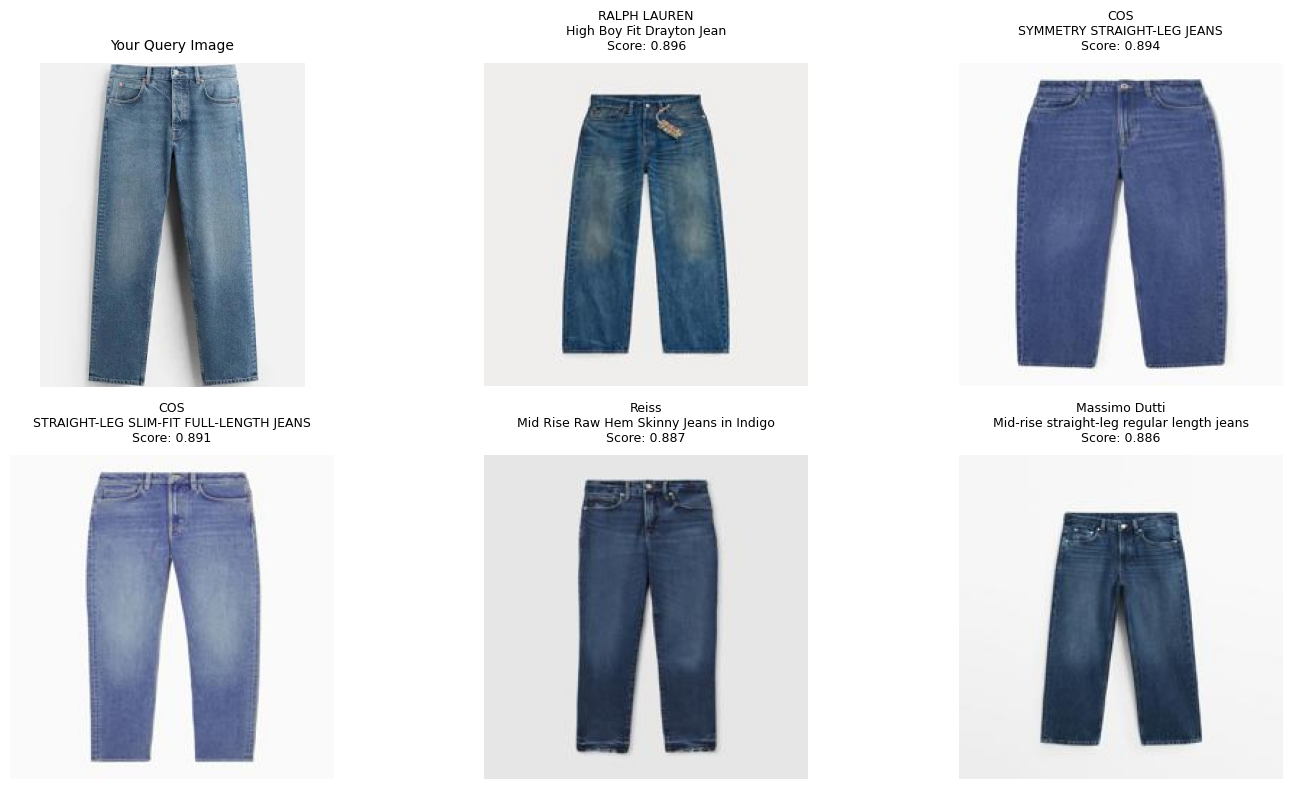

In [ ]:
# src/visualize.py
import os
import numpy as np
import pandas as pd
import faiss
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from pathlib import Path
try:
    from src.utils import get_logger, load_config
except ImportError:
    import logging
    print("Warning: src.utils not found. Using placeholder logger and config.")
    logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    logger = logging.getLogger(__name__)
    config = {"BASE_DIR": "/content/fashion-project"}

logger = get_logger(__name__) if 'get_logger' in globals() else logging.getLogger(__name__)
config = load_config() if 'load_config' in globals() else config

# Initialize EfficientNetB0 for feature extraction
model = tf.keras.applications.EfficientNetB0(
    weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3)
)

def extract_features(img_path: str) -> np.ndarray:
    """Extract features from an image using EfficientNetB0."""
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        features = model.predict(img_array, verbose=0)
        features = features.astype("float32")
        faiss.normalize_L2(features)
        logger.info(f"Extracted features for {img_path}: shape={features.shape}")
        return features
    except Exception as e:
        logger.error(f"Error extracting features from {img_path}: {e}")
        raise

def show_search_results(query_img_path: str, results_df: pd.DataFrame, scores: np.ndarray):
    """Display query image and top results in a grid layout."""
    plt.figure(figsize=(15, 8))

    # Display query image
    plt.subplot(2, 3, 1)
    try:
        query_img = Image.open(query_img_path)
        plt.imshow(query_img)
        plt.title("Your Query Image", fontsize=10, pad=10)
    except Exception as e:
        logger.warning(f"Failed to load query image {query_img_path}: {e}")
        plt.title("Query Image\n(Not Available)", fontsize=10)
    plt.axis("off")

    # Display top 5 results
    for i, (_, row) in enumerate(results_df.head(5).iterrows()):
        plt.subplot(2, 3, i + 2)
        try:
            image_path = Path(config["BASE_DIR"]) / "images" / f"{row['product_id']}.jpg"
            result_img = Image.open(image_path)
            plt.imshow(result_img)
            brand = row.get("brand", "Unknown Brand")
            name = row.get("product_name", "Unknown Product")
            title = f"{brand}\n{name}\nScore: {scores[i]:.3f}"
            plt.title(title, fontsize=9, pad=10)
        except Exception as e:
            logger.warning(f"Failed to load result image for product_id {row.get('product_id', 'N/A')}: {e}")
            plt.title("Result Image\n(Not Available)", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def visualize_similar_products():
    """Interactive widget for visual search in Colab."""
    # Load catalog and index
    catalog_path = Path(config["BASE_DIR"]) / "fashion_catalog.parquet"
    valid_ids_path = Path(config["BASE_DIR"]) / "valid_ids.csv"
    index_path = Path(config["BASE_DIR"]) / "fashion_index.faiss"

    try:
        df = pd.read_parquet(catalog_path)
        valid_ids = pd.read_csv(valid_ids_path)["id"].values.flatten()
        index = faiss.read_index(str(index_path))
    except Exception as e:
        logger.error(f"Error loading catalog/index: {e}")
        print(f"Error loading catalog/index: {e}")
        return

    # Create upload widget
    upload = widgets.FileUpload(
        description="Upload Image",
        accept="image/*",
        multiple=False
    )
    display(upload)

    def on_upload_change(change):
        """Handle image upload and perform visual search."""
        if not change.get("new"):
            logger.info("No file uploaded.")
            return

        try:
            # Process uploaded image
            file_info = next(iter(change["new"].values()))
            test_img_name = file_info["metadata"]["name"]
            test_img_path = f"temp_{test_img_name}"
            with open(test_img_path, "wb") as f:
                f.write(file_info["content"])

            # Extract features
            test_features = extract_features(test_img_path)
            logger.info(f"Query features shape: {test_features.shape}, index dimension: {index.d}")
            if test_features.shape[1] != index.d:
                raise ValueError(f"Feature dimension mismatch: query={test_features.shape[1]}, index={index.d}")

            # Search
            distances, indices = index.search(test_features, 5)
            valid_indices = [idx for idx in indices[0] if idx < len(valid_ids)]
            if not valid_indices:
                print("No valid results found.")
                return

            result_product_ids = [valid_ids[idx] for idx in valid_indices]
            results = df[df["product_id"].isin(result_product_ids)]
            valid_scores = [distances[0][i] for i, idx in enumerate(indices[0]) if idx in valid_indices]

            # Display results
            show_search_results(test_img_path, results, np.array(valid_scores))

        except Exception as e:
            logger.error(f"Error in visual search: {e}")
            print(f"Error in visual search: {e}")

        finally:
            # Clean up
            if os.path.exists(test_img_path):
                os.remove(test_img_path)
                logger.info(f"Cleaned up temporary file: {test_img_path}")

    # Attach the event handler
    upload.observe(on_upload_change, names="value")
    logger.info("Upload widget initialized.")

if __name__ == "__main__":
    print("Upload any fashion item to find similar products:")
    import nest_asyncio
    nest_asyncio.apply()  # Enable nested event loops in Colab
    visualize_similar_products()

In [ ]:
import pandas as pd
import numpy as np

def recommend_outfit(target_product_id):
    # Load necessary data
    df = pd.read_parquet('/content/fashion-project/fashion_catalog.parquet')
    target = df[df['product_id'] == target_product_id].iloc[0].to_dict()

    # Extract target attributes
    try:
        target_style = eval(target['style_attributes'])
        target_color = target_style.get('color')
        target_pattern = target_style.get('pattern', None)
    except:
        target_color = None
        target_pattern = None

    # Define smarter category compatibility
    if 'dress' in str(target['category_id']).lower():
        compatible_cats = {
            'shoes': ['shoe', 'footwear', 'sandal'],
            'bags': ['bag', 'clutch', 'handbag'],
            'accessories': ['jewelry', 'scarf', 'hat']
        }
    else:  # For jeans
        compatible_cats = {
            'tops': ['top', 'shirt', 'blouse', 't-shirt'],
            'shoes': ['shoe', 'boot', 'sneaker'],
            'jackets': ['jacket', 'cardigan', 'blazer']
        }

    recommendations = {}

    for category, keywords in compatible_cats.items():
        # Create candidate pool
        candidates = df[
            df['product_name'].str.lower().str.contains('|'.join(keywords), na=False)
        ].copy()

        # Skip if no candidates
        if len(candidates) == 0:
            recommendations[category] = None
            continue

        # Calculate match scores
        candidates['score'] = 0

        # Color match (if available)
        if target_color:
            candidates['score'] += candidates['style_attributes'].apply(
                lambda x: 2 if target_color in str(x) else 0
            )

        # Pattern match (if available)
        if target_pattern:
            candidates['score'] += candidates['style_attributes'].apply(
                lambda x: 1 if target_pattern in str(x) else 0
            )

        # Brand match bonus
        candidates['score'] += candidates['brand'].apply(
            lambda x: 1 if x == target['brand'] else 0
        )

        # Price range similarity
        if 'price' in target and 'price' in candidates:
            target_price = target['price']
            candidates['score'] += candidates['price'].apply(
                lambda x: 1 if 0.7*target_price <= x <= 1.3*target_price else 0
            )

        # Popularity score (if available in style_attributes)
        candidates['score'] += candidates['style_attributes'].apply(
            lambda x: 0.5 * float(eval(x).get('popularity', 0)) if 'popularity' in str(x) else 0
        )

        # Add randomization to break ties and introduce variability
        candidates['score'] += np.random.uniform(0, 0.1, size=len(candidates))

        # Get top 3 recommendations
        top_items = candidates.nlargest(3, 'score')
        recommendations[category] = top_items if len(top_items) > 0 else None

    return recommendations


Outfit recommendations for: Kristian Silk Tuxedo Dress
Main Item: RALPH LAUREN Kristian Silk Tuxedo Dress


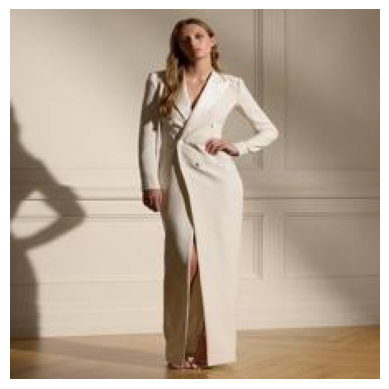


TOPS:
- RALPH LAUREN Belted Silk-Blend Shirtdress (Score: 1.100)


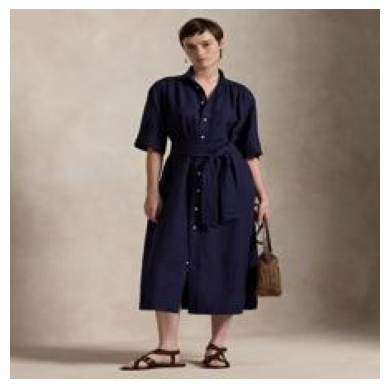

- RALPH LAUREN Cotton Twill Faux-Wrap Shirtdress (Score: 1.100)


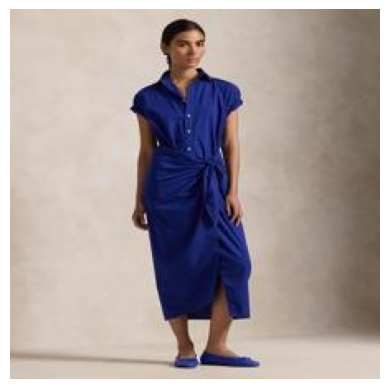

- RALPH LAUREN Linen-Blend Shirtdress (Score: 1.098)


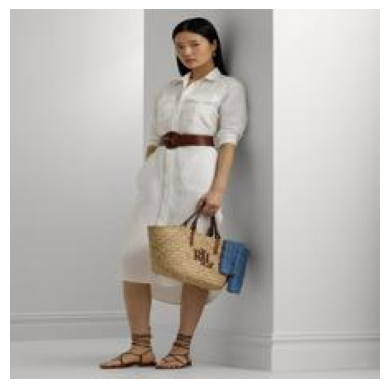


SHOES:
- RALPH LAUREN Boot Jean (Score: 1.097)


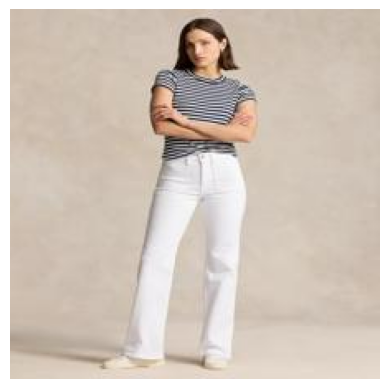

- RALPH LAUREN Vintage Boot Eastbend Jean (Score: 1.084)


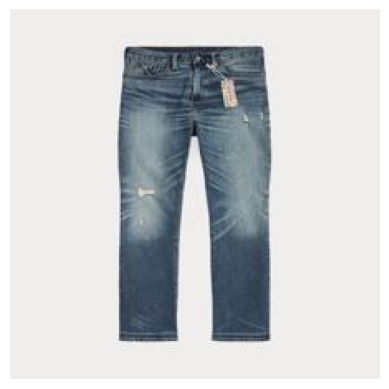

- RALPH LAUREN Kaida Relaxed Bootcut Jean (Score: 1.067)


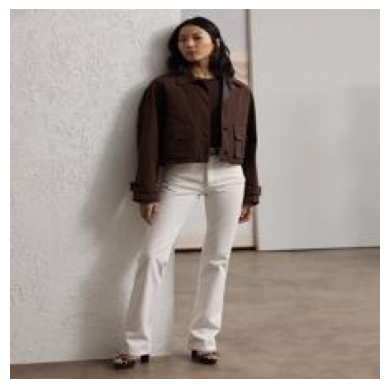


JACKETS:
- KarenMillen Clean Tailored Tuxedo Cape Sleeve Midi Blazer Dress (Score: 0.100)


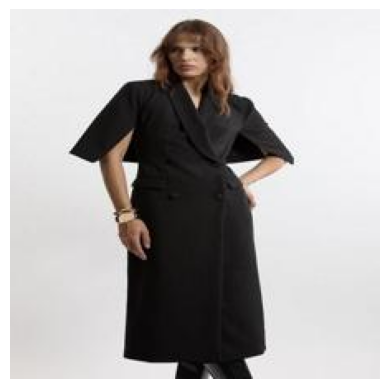

- KarenMillen Petite Crystal Embellished Tailored Blazer Mini Dress (Score: 0.099)


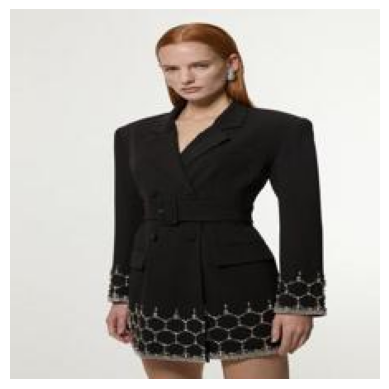

- By Anthropologie By Anthropologie Long-Sleeve Belted Cardigan Sweater Midi Dress (Score: 0.099)


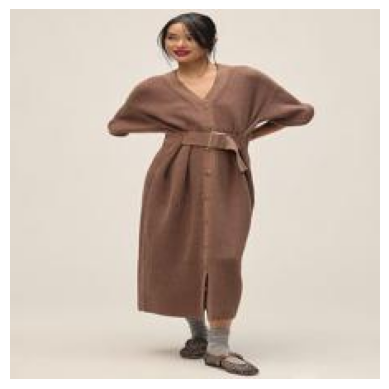

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Assuming df is already loaded
df = pd.read_parquet('/content/fashion-project/fashion_catalog.parquet')

def display_outfit_recommendations(product_id):
    outfit = recommend_outfit(product_id)
    target = df[df['product_id'] == product_id].iloc[0]

    print(f"\nOutfit recommendations for: {target['product_name']}")
    print(f"Main Item: {target['brand']} {target['product_name']}")

    # Display main item
    try:
        plt.imshow(Image.open(f"/content/fashion-project/images/{product_id}.jpg"))
        plt.axis('off')
        plt.show()
    except:
        print("Main item image not available")

    # Display recommendations
    for category, items in outfit.items():
        print(f"\n{category.upper()}:")
        if items is None or len(items) == 0:
            print(f"No recommendations found. Try these alternatives:")
            fallback = df[
                df['product_name'].str.lower().str.contains(category[:-1], na=False)
            ].sample(min(2, len(df)))
            for _, row in fallback.iterrows():
                print(f"- {row['brand']} {row['product_name']}")
                try:
                    plt.imshow(Image.open(f"/content/fashion-project/images/{row['product_id']}.jpg"))
                    plt.axis('off')
                    plt.show()
                except:
                    print("Image not available")
            continue

        for _, row in items.iterrows():
            print(f"- {row['brand']} {row['product_name']} (Score: {row['score']:.3f})")
            try:
                plt.imshow(Image.open(f"/content/fashion-project/images/{row['product_id']}.jpg"))
                plt.axis('off')
                plt.show()
            except:
                print("Image not available")

# Test with your product ID
display_outfit_recommendations('b613d7b5dfe86f3e695d931d31fd729fdf44e181f14079d3d8ca9082e8414683')

In [ ]:
import os

# List all files in the current directory
print("Files in /content/fashion-project:")
print(os.listdir())

# Check if specific files exist
files_to_check = [
    'fashion_catalog.parquet',
    'image_features.npy',
    'valid_ids.csv',
    'fashion_index.faiss'
]

print("\nChecking for key files:")
for file in files_to_check:
    exists = os.path.exists(file)
    print(f"{file}: {'Found' if exists else 'Not found'}")

# Check if the images folder exists and has files
images_dir = 'images'
if os.path.exists(images_dir) and os.path.isdir(images_dir):
    num_images = len(os.listdir(images_dir))
    print(f"\nImages folder found with {num_images} files.")
else:
    print("\nImages folder not found or empty.")

Files in /content/fashion-project:
['fashion_index.faiss', 'dresses_bd_processed_data.csv', 'temp_Test_image.jpg', 'temp_Test3.webp', 'fashion_catalog.parquet', 'jeans_bd_processed_data.csv', 'fashion-project', 'images', 'image_features.npy', 'valid_ids.csv']

Checking for key files:
fashion_catalog.parquet: Found
image_features.npy: Found
valid_ids.csv: Found
fashion_index.faiss: Found

Images folder found with 17474 files.


In [ ]:
!ls -l /content/fashion-project

total 220036
-rw------- 1 root root 28211062 Jun  9 00:26 dresses_bd_processed_data.csv
-rw-r--r-- 1 root root  9563234 Jun  9 00:26 fashion_catalog.parquet
-rw-r--r-- 1 root root 89466925 Jun  9 01:04 fashion_index.faiss
drwxr-xr-x 4 root root     4096 Jun  9 00:25 fashion-project
-rw-r--r-- 1 root root 89467008 Jun  9 01:03 image_features.npy
drwxr-xr-x 2 root root  1941504 Jun  9 00:35 images
-rw------- 1 root root  5485445 Jun  9 00:26 jeans_bd_processed_data.csv
-rw-r--r-- 1 root root    10066 Jun  9 01:05 temp_Test3.webp
-rw-r--r-- 1 root root     9938 Jun  9 01:06 temp_Test_image.jpg
-rw-r--r-- 1 root root  1135813 Jun  9 01:03 valid_ids.csv


In [ ]:
# Install a specific stable version
!pip install aioredis==1.3.1

  Using cached aioredis-1.3.1-py3-none-any.whl.metadata (22 kB)
Using cached aioredis-1.3.1-py3-none-any.whl (65 kB)
  Attempting uninstall: aioredis
    Found existing installation: aioredis 2.0.1
    Uninstalling aioredis-2.0.1:
      Successfully uninstalled aioredis-2.0.1


In [ ]:
import pandas as pd
catalog_df = pd.read_parquet('/content/fashion-project/fashion_catalog.parquet')
product = catalog_df[catalog_df['product_id'] == '325eeee47b70f4123d8aab5919cbdabe9584df625891b3e6fafc4101c60daad8']
print(product[['product_id', 'product_name', 'feature_image_s3', 'pdp_images_s3']])

                                             product_id  \
3876  325eeee47b70f4123d8aab5919cbdabe9584df625891b3...   

                    product_name  \
3876  Petites Citron Linen Dress   

                                       feature_image_s3  \
3876  https://gallery.stylumia.com/originals/2024/08...   

                                          pdp_images_s3  
3876  ['https://gallery.stylumia.com/originals/2024/...  


In [ ]:
!pip install fastapi uvicorn python-multipart numpy pandas faiss-cpu tensorflow pillow aioredis scikit-learn

In [ ]:
!pip install fastapi uvicorn pyngrok python-multipart

In [ ]:
cd /content/fashion-project/

/content


In [ ]:
!pip install fastapi uvicorn pandas numpy faiss-cpu Pillow tensorflow scikit-learn pyarrow pyngrok nest_asyncio

In [ ]:
!pip show aioredis


In [ ]:
!pip install redis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 4.6 MB/s eta 0:00:00


In [ ]:
from pyngrok import ngrok

# Terminate any existing ngrok tunnels
print("Terminating existing ngrok tunnels...")
ngrok.kill() # This is the key command to clear previous tunnels
print("Existing ngrok tunnels terminated.")

# Reset pyngrok to ensure a clean state
ngrok.set_auth_token("") # Clear any old auth token if set

Terminating existing ngrok tunnels...
Existing ngrok tunnels terminated.


In [ ]:
from pyngrok import ngrok
import os

# Kill all ngrok tunnels
print("Killing all ngrok tunnels...")
ngrok.kill()

# Kill uvicorn process manually
os.system("fuser -k 8005/tcp")  # This works in Linux (Colab/Jupyter/WSL)


In [ ]:
import pandas as pd
import os

# Load your catalog DataFrame
catalog_df = pd.read_parquet('/content/fashion-project/fashion_catalog.parquet')

print("Columns in your catalog DataFrame:")
print(catalog_df.columns)

print("\nFirst 5 rows of your catalog DataFrame (to see actual data):")
print(catalog_df.head())

print("\nCheck for 'name' and 'category' columns:")
if 'name' in catalog_df.columns:
    print(f"'name' column exists. First 5 non-null values:\n{catalog_df['name'].dropna().head()}")
else:
    print("'name' column DOES NOT exist.")

if 'category' in catalog_df.columns:
    print(f"'category' column exists. First 5 non-null values:\n{catalog_df['category'].dropna().head()}")
else:
    print("'category' column DOES NOT exist.")

# Get a sample product_id from your valid_ids for checking images
valid_ids = pd.read_csv('/content/fashion-project/valid_ids.csv')['id'].tolist()
if valid_ids:
    sample_product_id = valid_ids[0]
    print(f"\nSample product ID from valid_ids.csv: {sample_product_id}")
    sample_product_row = catalog_df[catalog_df['product_id'] == sample_product_id]
    if not sample_product_row.empty:
        print(f"Details for sample product ID {sample_product_id}:")
        print(sample_product_row.to_dict('records')[0])
    else:
        print(f"Sample product ID {sample_product_id} not found in catalog_df.")
else:
    print("No valid IDs found in valid_ids.csv.")

Columns in your catalog DataFrame:
Index(['selling_price', 'discount', 'category_id', 'meta_info', 'product_id',
       'pdp_url', 'sku', 'brand', 'department_id', 'last_seen_date',
       'launch_on', 'mrp', 'product_name', 'feature_image_s3', 'channel_id',
       'feature_list', 'description', 'style_attributes', 'pdp_images_s3'],
      dtype='object')

First 5 rows of your catalog DataFrame (to see actual data):
          selling_price  discount  category_id  \
0  {'INR': 474848.9539}       0.0           30   
1  {'INR': 464648.6919}       0.0           30   
2   {'INR': 29496.0812}       0.0           30   
3   {'INR': 17156.9392}       0.0           30   
4   {'INR': 26079.5467}       0.0           30   

                                           meta_info  \
0  Slim fit. Designed to hit at the ankle. UK siz...   
1  Slim fit. Designed to hit at the ankle. UK siz...   
2  Fit-and-flare silhouette. Intended to hit at t...   
3  Fits true to size; take your normal size, Stra...   


In [4]:
# %%writefile /content/fashion-project/main.py
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware
from fastapi.staticfiles import StaticFiles
from contextlib import asynccontextmanager
import numpy as np
import pandas as pd
import faiss
from PIL import Image
import io
import tensorflow as tf
import redis.asyncio as aioredis
import os
import logging
from typing import Dict, List
from pydantic import BaseModel
import time
import json

os.environ["CUDA_VISIBLE_DEVICES"] = ""

@asynccontextmanager
async def lifespan(app: FastAPI):
    await search_engine.init_redis()
    logger.info("Application startup complete")
    yield
    if search_engine.redis_client:
        await search_engine.redis_client.close()
        logger.info("Redis connection closed on shutdown")

app = FastAPI(
    title="Fashion Visual Search API",
    description="API for visual fashion search and recommendations",
    version="2.0.0",
    lifespan=lifespan
)

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

app.mount("/images", StaticFiles(directory="/content/fashion-project/images"), name="images")

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class EnhancedFashionSearchEngine:
    def __init__(self):
        self.model = tf.keras.applications.EfficientNetB0(
            include_top=False, weights='imagenet', pooling='avg'
        )
        self.catalog_df = None
        self.features = None
        self.valid_ids = None
        self.index = None
        self.redis_client = None
        self._init_engines()

    async def init_redis(self):
        redis_url = os.getenv("REDIS_URL", "redis://localhost:6379")
        try:
            self.redis_client = await aioredis.from_url(
                redis_url, encoding="utf-8", decode_responses=True
            )
            logger.info("Redis connection initialized")
        except Exception as e:
            logger.error(f"Redis connection error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"Redis connection error during startup: {str(e)}")

    def _init_engines(self):
        try:
            self.catalog_df = pd.read_parquet('/content/fashion-project/fashion_catalog.parquet')
            self.catalog_df['product_name'] = self.catalog_df['product_name'].fillna('Unknown Product')
            self.catalog_df['category_id'] = self.catalog_df['category_id'].fillna('Unknown Category')
            missing_images = self.catalog_df['feature_image_s3'].isnull().sum()
            logger.info(f"Catalog loaded: {len(self.catalog_df)} items, missing images: {missing_images}")
            self.load_index()
            logger.info("Fashion Search Engine initialized")
        except Exception as e:
            logger.error(f"Initialization error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"Initialization error: {str(e)}")

    def load_index(self):
        try:
            self.features = np.load('/content/fashion-project/image_features.npy')
            self.valid_ids = pd.read_csv('/content/fashion-project/valid_ids.csv')['id'].tolist()
            self.index = faiss.read_index('/content/fashion-project/fashion_index.faiss')
            faiss.normalize_L2(self.features)

            catalog_ids = set(self.catalog_df['product_id'].astype(str))
            valid_ids_set = set(self.valid_ids)
            missing_ids = valid_ids_set - catalog_ids
            if missing_ids:
                logger.warning(f"Found {len(missing_ids)} valid_ids from FAISS index not in catalog_df. Filtering.")
                self.valid_ids = [id_ for id_ in self.valid_ids if id_ in catalog_ids]

            logger.info(f"FAISS index loaded with {len(self.valid_ids)} valid IDs")
        except Exception as e:
            logger.error(f"Error loading index: {str(e)}")
            raise HTTPException(status_code=500, detail=f"Index loading error: {str(e)}")

    def extract_features(self, image: Image.Image) -> np.ndarray:
        try:
            image = image.resize((224, 224))
            image_array = np.array(image)
            if image_array.shape[-1] == 4:
                image_array = image_array[:, :, :3]
            image_array = np.expand_dims(image_array, axis=0)
            image_array = tf.keras.applications.efficientnet.preprocess_input(image_array)
            features = self.model.predict(image_array, verbose=0)
            faiss.normalize_L2(features)
            logger.info(f"Extracted features: shape={features.shape}, min={features.min()}, max={features.max()}")
            return features
        except Exception as e:
            logger.error(f"Feature extraction error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"Feature extraction error: {str(e)}")

    async def search_similar_items(self, image: Image.Image, top_k: int = 5) -> List[Dict]:
        try:
            features = self.extract_features(image)
            distances, indices = self.index.search(features, top_k)
            results = []
            for idx, dist in zip(indices[0], distances[0]):
                if idx < len(self.valid_ids):
                    product_id = self.valid_ids[idx]
                    product_row = self.catalog_df[self.catalog_df['product_id'] == product_id]
                    if not product_row.empty:
                        product = product_row.to_dict('records')[0]

                        image_url = f"/images/{product_id}.jpg"
                        local_file_path = os.path.join('/content/fashion-project/images', f"{product_id}.jpg")

                        if not os.path.exists(local_file_path):
                            image_url = product.get('feature_image_s3', "https://via.placeholder.com/100?text=No+Image")
                            if image_url == "https://via.placeholder.com/100?text=No+Image":
                                logger.warning(f"No local image or S3 URL for product_id {product_id}. Using placeholder.")
                            else:
                                logger.warning(f"Local image not found for product_id {product_id}. Falling back to S3: {image_url}")

                        results.append({
                            "product_id": str(product_id),
                            "name": product.get('product_name', 'Unknown Product'),
                            "category": product.get('category_id', 'Unknown Category'),
                            "image_url": image_url,
                            "similarity_score": float(dist)
                        })
                        logger.debug(f"Added result for product_id {product_id}: {results[-1]}")
                    else:
                        logger.warning(f"Product ID {product_id} from FAISS index not found in catalog_df. Skipping.")
                else:
                    logger.warning(f"Index {idx} from FAISS is out of bounds for valid_ids. Skipping.")
            logger.info(f"Search returned {len(results)} results.")
            return results
        except Exception as e:
            logger.error(f"Visual search error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"Visual search error: {str(e)}")

    def recommend_outfit(self, target_product_id: str) -> Dict[str, List[Dict]]:
        try:
            target = self.catalog_df[self.catalog_df['product_id'] == target_product_id]
            if target.empty:
                logger.warning(f"Target Product ID {target_product_id} not found for outfit recommendation.")
                raise HTTPException(status_code=404, detail=f"Product ID {target_product_id} not found")
            target = target.iloc[0].to_dict()

            try:
                target_style = json.loads(target['style_attributes']) if pd.notna(target['style_attributes']) and target['style_attributes'] else {}
                target_color = target_style.get('color')
                target_pattern = target_style.get('pattern')
            except json.JSONDecodeError as e:
                logger.warning(f"Could not parse style_attributes for product {target_product_id}: {e}")
                target_color = None
                target_pattern = None
            except TypeError as e:
                logger.warning(f"Type error for style_attributes of product {target_product_id}: {e}")
                target_color = None
                target_pattern = None

            if 'dress' in str(target['category_id']).lower():
                compatible_cats = {
                    'shoes': ['shoe', 'sandal', 'boot'],
                    'bags': ['bag', 'clutch', 'handbag'],
                    'accessories': ['jewelry', 'scarf', 'hat']
                }
            else:
                compatible_cats = {
                    'tops': ['top', 'shirt', 'blouse', 't-shirt'],
                    'bottoms': ['pant', 'jeans', 'skirt'],
                    'shoes': ['shoe', 'sneaker', 'boot']
                }

            recommendations = {}
            for category, keywords in compatible_cats.items():
                candidates = self.catalog_df[
                    self.catalog_df['product_name'].str.lower().str.contains('|'.join(keywords), na=False)
                ].copy()

                candidates = candidates[candidates['product_id'] != target_product_id]

                if len(candidates) == 0:
                    recommendations[category] = []
                    continue

                candidates['score'] = 0.0

                candidates['style_attributes_parsed'] = candidates['style_attributes'].apply(
                    lambda x: json.loads(x) if pd.notna(x) and x else {}
                )

                if target_color:
                    candidates['score'] += candidates['style_attributes_parsed'].apply(
                        lambda x: 2.0 if target_color in x.get('color', '') else 0.0
                    )
                if target_pattern:
                    candidates['score'] += candidates['style_attributes_parsed'].apply(
                        lambda x: 1.0 if target_pattern in x.get('pattern', '') else 0.0
                    )
                candidates['score'] += candidates['style_attributes_parsed'].apply(
                    lambda x: 0.5 * float(x.get('popularity', 0))
                )
                candidates['score'] += candidates['brand'].apply(
                    lambda x: 1.0 if x == target['brand'] else 0.0
                )

                target_price = 0.0
                if pd.notna(target.get('selling_price')):
                    try:
                        target_price = float(json.loads(target['selling_price']).get('INR', 0.0))
                    except (json.JSONDecodeError, TypeError):
                        logger.warning(f"Could not parse target selling_price for {target_product_id}")

                if target_price > 0:
                    candidates['parsed_price'] = candidates['selling_price'].apply(
                        lambda x: float(json.loads(x).get('INR', 0.0)) if pd.notna(x) and x else 0.0
                    )
                    candidates['score'] += candidates['parsed_price'].apply(
                        lambda x: 1.0 if 0.7 * target_price <= x <= 1.3 * target_price else 0.0
                    )

                candidates['score'] += np.random.uniform(0, 0.01, size=len(candidates))

                top_items = candidates.nlargest(3, 'score')[
                    ['product_id', 'product_name', 'brand', 'selling_price', 'feature_image_s3', 'score']
                ].to_dict('records')

                for item in top_items:
                    price_val = 0.0
                    if pd.notna(item.get('selling_price')):
                        try:
                            price_val = float(json.loads(item['selling_price']).get('INR', 0.0))
                        except (json.JSONDecodeError, TypeError):
                            pass
                    item['price'] = price_val

                    image_url = f"/images/{item['product_id']}.jpg"
                    local_file_path = os.path.join('/content/fashion-project/images', f"{item['product_id']}.jpg")

                    if not os.path.exists(local_file_path):
                        image_url = item.get('feature_image_s3', "https://via.placeholder.com/100?text=No+Image")
                        if image_url == "https://via.placeholder.com/100?text=No+Image":
                            logger.warning(f"No local image or S3 URL for recommended product {item['product_id']}. Using placeholder.")
                        else:
                            logger.warning(f"Local image not found for recommended product {item['product_id']}. Falling back to S3: {image_url}")

                    item['image_url'] = image_url
                    item.pop('selling_price', None)
                    item.pop('feature_image_s3', None)

                recommendations[category] = top_items

            logger.info(f"Outfit recommendations generated for product_id {target_product_id}")
            return recommendations
        except Exception as e:
            logger.error(f"Outfit recommendation error: {str(e)}")
            raise HTTPException(status_code=500, detail=f"Outfit recommendation error: {str(e)}")

class OutfitRequest(BaseModel):
    product_id: str
    max_items_per_category: int = 3

search_engine = EnhancedFashionSearchEngine()
start_time = time.time()

@app.get("/", response_class=JSONResponse)
async def root():
    logger.info("Root endpoint accessed")
    return {
        "message": "Fashion Visual Search API",
        "version": "2.0.0",
        "status": "running",
        "endpoints": {
            "visual_search": "/search/visual",
            "outfit_recommendation": "/search/outfit",
            "health_check": "/health"
        }
    }

@app.post("/search/visual", response_class=JSONResponse)
async def visual_search(file: UploadFile = File(...), top_k: int = 5):
    logger.info("Visual search endpoint accessed")
    try:
        contents = await file.read()
        image = Image.open(io.BytesIO(contents))
        results = await search_engine.search_similar_items(image, top_k)
        return {"results": results}
    except Exception as e:
        logger.error(f"Visual search endpoint error: {str(e)}")
        raise HTTPException(status_code=500, detail=f"Visual search error: {str(e)}")

@app.post("/search/outfit", response_class=JSONResponse)
async def outfit_recommendation(request: OutfitRequest):
    logger.info("Outfit recommendation endpoint accessed")
    try:
        recommendations = search_engine.recommend_outfit(request.product_id)
        return {"recommendations": recommendations}
    except Exception as e:
        logger.error(f"Outfit recommendation endpoint error: {str(e)}")
        raise HTTPException(status_code=500, detail=f"Outfit recommendation error: {str(e)}")

@app.get("/health", response_class=JSONResponse)
async def health_check():
    logger.info("Health check endpoint accessed")
    return {
        "status": "healthy",
        "uptime": time.time() - start_time,
        "active_connections": 0,
        "cache_hit_rate": 0.0,
        "avg_response_time": 0.0
    }

In [5]:
import os

# Check if the base directory exists
if os.path.exists('/content/fashion-project'):
    print("/content/fashion-project exists.")
else:
    print("/content/fashion-project DOES NOT exist. This is a problem.")

# List contents of the base directory
print("\nContents of /content/fashion-project:")
!ls -F /content/fashion-project/

# Check if the images directory exists
if os.path.exists('/content/fashion-project/images'):
    print("\n/content/fashion-project/images exists.")
else:
    print("\n/content/fashion-project/images DOES NOT exist. This is the likely issue!")

# List contents of the images directory (if it exists)
if os.path.exists('/content/fashion-project/images'):
    print("\nContents of /content/fashion-project/images (first 10 files):")
    !ls -F /content/fashion-project/images | head -n 10
    # Check for a specific file you know should be there
    sample_image_id = "f34a32f2b9f830d5db6bd84c7423d6a8064f1e7a290957c609a3bbd7f8db49bd" # From your debug output
    if os.path.exists(f"/content/fashion-project/images/{sample_image_id}.jpg"):
        print(f"\n{sample_image_id}.jpg FOUND in /content/fashion-project/images.")
    else:
        print(f"\n{sample_image_id}.jpg NOT FOUND in /content/fashion-project/images. This is a critical issue.")

/content/fashion-project exists.

Contents of /content/fashion-project:
dresses_bd_processed_data.csv  image_features.npy	    __pycache__/
fashion_catalog.parquet        images/			    temp_Test_image.jpg
fashion_index.faiss	       jeans_bd_processed_data.csv  valid_ids.csv
fashion-project/	       main.py

/content/fashion-project/images exists.

Contents of /content/fashion-project/images (first 10 files):
0002732c1a93396ab12789afaea47755af8579d38a4096054cbb05f5463d96b5.jpg
00029897a53a74bd8cce87c9c6711c83fecb010497ee30cfab271060ee93fcec.jpg
0003f402060f4dbd72943a43893ecd347e33eae8fa5ae8d3a3a74b40d6594faa.jpg
000526c658c9e6d03385a71edef156accc697a16c6edafadbc3b01a3b6e98ab7.jpg
00086378cb48ebe15ed73d4ce4bc54cbe813cf13d2c8e1b31dcb9e2570aff771.jpg
000bc73f350c619522f89708e16d7f395ca0678143abf41ee677958ea36ab7eb.jpg
001683e8331aaba5387703b0335bafcc21ee90b366f4a5c0fad682b19cfba566.jpg
00169b6a2577bd5f9ad65d5e0ae08f053bcfdd57469d0720d2a5da739e88e93c.jpg
001cc7734a6ded96796a018bbc477f2c02c591

In [ ]:
with open('main.py', 'r') as f:
    content = f.read()
    print('search_similar_items' in content)

True


In [ ]:
import pandas as pd
df = pd.read_parquet('/content/fashion-project/fashion_catalog.parquet')
sample_ids = [
    '325eeee47b70f4123d8aab5919cbdabe9584df625891b3e6fafc4101c60daad8',
    '26fa4336a0bfcedb1fc341573e9d564fce27e6c690a52347817333826534108a',
    'fdcd85a14b519339dc48ec8adaccd1d46273334d337021925b9d03a9ad8b885'
]
print(df[df['product_id'].isin(sample_ids)][['product_id', 'product_name', 'category_id', 'feature_image_s3']])
print(df.isna().sum())

                                             product_id  \
3876  325eeee47b70f4123d8aab5919cbdabe9584df625891b3...   
5602  26fa4336a0bfcedb1fc341573e9d564fce27e6c690a523...   

                                          product_name  category_id  \
3876                        Petites Citron Linen Dress           30   
5602  Structured Crepe Tailored Cape Pencil Midi Dress           30   

                                       feature_image_s3  
3876  https://gallery.stylumia.com/originals/2024/08...  
5602  https://gallery.stylumia.com/originals/2024/10...  
selling_price          0
discount               0
category_id            0
meta_info             71
product_id             0
pdp_url                0
sku                    0
brand                  0
department_id          0
last_seen_date         0
launch_on              0
mrp                    0
product_name           0
feature_image_s3       0
channel_id             0
feature_list           0
description         5898
style_att

In [ ]:
from pyngrok import ngrok
ngrok.kill()  # Kills all existing ngrok tunnels


In [6]:

import os
os.chdir('/content/fashion-project/')

from pyngrok import ngrok
import threading
import uvicorn
import nest_asyncio
import time

print("Terminating existing ngrok tunnels...")
ngrok.kill()
print("Existing ngrok tunnels terminated.")
time.sleep(5) # Give it some time to clear

# --- ADD OR UNCOMMENT AND REPLACE THIS LINE ---
# IMPORTANT: Replace "YOUR_NGROK_AUTH_TOKEN_HERE" with your actual ngrok authtoken
ngrok.set_auth_token("2yEgY4eXJznSPxC1rCoRoZsSGrQ_5zmsD9NfURf2xrAUbZY2c") # <--- PASTE YOUR AUTH TOKEN HERE!
# ---------------------------------------------

def run_uvicorn():
    """Runs the Uvicorn server for the FastAPI app."""
    # Apply nest_asyncio to allow nested event loops (necessary for Colab)
    nest_asyncio.apply()
    uvicorn.run("main:app", host="0.0.0.0", port=8033)

# Start Uvicorn in a separate thread
thread = threading.Thread(target=run_uvicorn)
thread.start()


time.sleep(20) # Increased sleep time for better reliability

# Connect ngrok to the FastAPI port
public_url = ngrok.connect(8033)
print(f"Uvicorn running on: {public_url}")

Terminating existing ngrok tunnels...
Existing ngrok tunnels terminated.


INFO:     Started server process [44618]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8033 (Press CTRL+C to quit)


Uvicorn running on: NgrokTunnel: "https://5744-34-106-160-160.ngrok-free.app" -> "http://localhost:8033"


In [ ]:
import pandas as pd

# Load your catalog (adjust path if necessary)
catalog_df = pd.read_parquet('/content/fashion-project/fashion_catalog.parquet')

# Display the first few product_ids
print("b613d7b5dfe86f3e695d931d31fd729fdf44e181f14079d3d8ca9082e8414683")
print(catalog_df['product_id'].head())

# Pick one or two product_ids to check manually, e.g., 'your_sample_product_id'

b613d7b5dfe86f3e695d931d31fd729fdf44e181f14079d3d8ca9082e8414683
0    b613d7b5dfe86f3e695d931d31fd729fdf44e181f14079...
1    482b10a23f8d00cfc7c9bbeeac4e26d25dd303d8e62e97...
2    3508b052ef7a5eea820423b97713612bc92a3f2301a3d3...
3    6360245240b68885bd4dbcef8d8856c0fb13f1314769f5...
4    5d07037957e64d1e218499cb7d7a8e5e57aa59249bb806...
Name: product_id, dtype: object


In [ ]:
import pandas as pd
import os

# --- Configuration ---
CATALOG_PATH = '/content/fashion-project/fashion_catalog.parquet'
IMAGE_DIR = '/content/fashion-project/images'
POSSIBLE_EXTENSIONS = ['.jpg', '.jpeg', '.png'] # Add any other extensions your images might have

print(f"--- Checking Image Filename Consistency ---")
print(f"Catalog Path: {CATALOG_PATH}")
print(f"Image Directory: {IMAGE_DIR}")
print(f"Possible Extensions: {POSSIBLE_EXTENSIONS}")
print("-" * 40)

# 1. Load the catalog DataFrame
try:
    catalog_df = pd.read_parquet(CATALOG_PATH)
    # Convert product_id to string to ensure consistent comparison with filenames
    df_product_ids = set(catalog_df['product_id'].astype(str).tolist())
    print(f"Found {len(df_product_ids)} unique product_ids in the catalog.")
except Exception as e:
    print(f"Error loading catalog DataFrame: {e}")
    exit()

# 2. Get a list of actual image filenames from the directory
actual_image_files_with_ext = set()
actual_image_basenames = set() # Filename without extension

if not os.path.isdir(IMAGE_DIR):
    print(f"Error: Image directory '{IMAGE_DIR}' does not exist. Please check your path.")
    exit()

for filename in os.listdir(IMAGE_DIR):
    # Check if the file has one of the expected image extensions (case-insensitive check for extensions)
    if any(filename.lower().endswith(ext) for ext in POSSIBLE_EXTENSIONS):
        actual_image_files_with_ext.add(filename)
        # Extract basename (which should be the product_id)
        basename, ext = os.path.splitext(filename)
        actual_image_basenames.add(basename)

print(f"Found {len(actual_image_files_with_ext)} image files in the directory.")
print("-" * 40)

# 3. Compare product_ids from DataFrame with actual filenames on disk
print("--- Missing Images for Product IDs in Catalog ---")
missing_images_count = 0
for pid in df_product_ids:
    found_match = False
    for ext in POSSIBLE_EXTENSIONS:
        # Construct the full expected path for each product_id and extension
        expected_path = os.path.join(IMAGE_DIR, f"{pid}{ext}")
        if os.path.exists(expected_path):
            found_match = True
            break

    if not found_match:
        print(f"MISSING IMAGE: Product ID '{pid}' from catalog has no matching file (e.g., {pid}.jpg) in '{IMAGE_DIR}'")
        missing_images_count += 1

if missing_images_count == 0:
    print("All product IDs in the catalog have a matching image file found.")
else:
    print(f"Total {missing_images_count} product IDs are missing corresponding image files.")

print("-" * 40)

# 4. (Optional) Check for extra images in the directory that are not in the catalog
print("--- Extra Images in Directory (Not Referenced in Catalog) ---")
extra_images_count = 0
for basename in actual_image_basenames:
    if basename not in df_product_ids:
        # Only report if it's not a common hidden file like .ipynb_checkpoints
        if not basename.startswith('.'):
            print(f"EXTRA IMAGE: File '{basename}.*' exists but '{basename}' is not found as a product_id in the catalog.")
            extra_images_count += 1

if extra_images_count == 0:
    print("No extra image files found that don't correspond to a product ID in the catalog.")
else:
    print(f"Total {extra_images_count} extra image files found.")

print("-" * 40)
print("--- Consistency Check Complete ---")

--- Checking Image Filename Consistency ---
Catalog Path: /content/fashion-project/fashion_catalog.parquet
Image Directory: /content/fashion-project/images
Possible Extensions: ['.jpg', '.jpeg', '.png']
----------------------------------------
Found 17474 unique product_ids in the catalog.
Found 17474 image files in the directory.
----------------------------------------
--- Missing Images for Product IDs in Catalog ---
All product IDs in the catalog have a matching image file found.
----------------------------------------
--- Extra Images in Directory (Not Referenced in Catalog) ---
No extra image files found that don't correspond to a product ID in the catalog.
----------------------------------------
--- Consistency Check Complete ---


In [ ]:
import pandas as pd
import json # Import json to potentially parse style_attributes

# Load your catalog data
try:
    catalog_df = pd.read_parquet('/content/fashion-project/fashion_catalog.parquet')
    print(f"Catalog loaded with {len(catalog_df)} items.")
except FileNotFoundError:
    print("Error: fashion_catalog.parquet not found. Make sure it's at /content/fashion-project/fashion_catalog.parquet")
    # Exit or handle error appropriately if file is missing

# --- Inspection 1: Unique Category IDs and their counts ---
print("\n--- Unique Category IDs and Counts ---")
print(catalog_df['category_id'].value_counts().sort_index())

# --- Inspection 2: Sample Product Names for some Category IDs ---
print("\n--- Sample Product Names per Category (Top 3 per category) ---")
# Get the top N most frequent categories to inspect
top_categories = catalog_df['category_id'].value_counts().head(5).index.tolist()

for cat_id in top_categories:
    print(f"\nCategory ID: {cat_id}")
    sample_names = catalog_df[catalog_df['category_id'] == cat_id]['product_name'].head(3).tolist()
    print(f"  Sample product names: {sample_names}")

# --- Inspection 3: Sample style_attributes (to understand its structure) ---
print("\n--- Sample Style Attributes (if any) ---")
# Find a row with non-null style_attributes
sample_style_row = catalog_df[catalog_df['style_attributes'].notna()].head(1)
if not sample_style_row.empty:
    try:
        print(f"Sample style_attributes raw: {sample_style_row['style_attributes'].iloc[0]}")
        parsed_style = json.loads(sample_style_row['style_attributes'].iloc[0])
        print(f"Sample style_attributes parsed: {parsed_style}")
        print(f"Sample color: {parsed_style.get('color')}, Sample pattern: {parsed_style.get('pattern')}")
    except json.JSONDecodeError as e:
        print(f"Could not decode style_attributes for sample row: {e}")
        print(f"Raw value: {sample_style_row['style_attributes'].iloc[0]}")
else:
    print("No rows with style_attributes found or they are all null.")

# --- Inspection 4: Sample selling_price (to understand its structure) ---
print("\n--- Sample Selling Price (if any) ---")
sample_price_row = catalog_df[catalog_df['selling_price'].notna()].head(1)
if not sample_price_row.empty:
    try:
        print(f"Sample selling_price raw: {sample_price_row['selling_price'].iloc[0]}")
        parsed_price = json.loads(sample_price_row['selling_price'].iloc[0])
        print(f"Sample selling_price parsed: {parsed_price}")
        print(f"Sample INR price: {parsed_price.get('INR')}")
    except json.JSONDecodeError as e:
        print(f"Could not decode selling_price for sample row: {e}")
        print(f"Raw value: {sample_price_row['selling_price'].iloc[0]}")
else:
    print("No rows with selling_price found or they are all null.")